In [16]:
using Plots

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1273


In [1]:
using LinearAlgebra

# 1D Finite volume for heat conduction

- Heat conduction, with constant coefficients and no heat generation inside the material, the Fourier equation:
$$
\rho C_p \, \frac{\partial T}{\partial t} = -k \, \frac{\partial^2 T}{\partial x^2}
$$


http://www.csc.kth.se/utbildning/kth/kurser/DN2255/ndiff13/Lecture3.pdf

- Relation between caracteristic time $\Delta t$ and length scale $\Delta x$:
$$
\Delta x \sim \sqrt{ \alpha \Delta t }
$$

$\alpha = \frac{k}{\rho \, Cp}$ is the thermal diffusivity.

- Spatial discretization for interior points:

$$
\rho C_p dx \, \frac{\partial T_i}{\partial t} = k \, \frac{T_{i-1} - 2T_{i} + T_{i+1}}{dx}
$$

i.e.

$$
\frac{\partial T_i}{\partial t} = \frac{\alpha}{dx^2} \, \left[ T_{i-1} - 2T_{i} + T_{i+1} \right]
$$

- Boundary coundary conditions ($i = 1$), using half-control volume  ($T_1$ is the temperature of the surface):

$$
\rho C_p \frac{dx}{2} \, \frac{\partial T_1}{\partial t} = k \, \frac{- T_1 + T_{2}}{dx} + S_1(T,\, t)
$$

Considering convection at the surface: $S_1(T, t) = h_1\, \left( T_{source} - T_1 \right)$

$$
\rho C_p \frac{dx}{2} \, \frac{\partial T_1}{\partial t} =
k \, \frac{-(1 + h_1dx/k)T_1 + T_{2}}{dx} + h_1\,  T_{source} 
$$

i.e.


$$
\frac{\partial T_1}{\partial t} =
\frac{\alpha}{dx^2} \, \left[ -(2 + 2\,h_1dx/k)T_1 + 2\,T_{2} \right]
+ \frac{ 2\, h_1 }{ \rho Cp  \,dx }T_{source} 
$$



- fixed surface temperature $T_{surface} = T_0(t)$, solve for $N-1$ unknows... ?

- Time integration:

Linear system (matrix) formulation:
$$
\frac{\partial T}{\partial t} = A \, T + S(t)
$$

Time discretization using theta-method:
$$
T^{k+1} - T^{k} = \theta\, dt \left[ A \, T^{k+1} + S^{k+1} \right]
+ (1-\theta)\, dt \left[ A \, T^{k} + S^{k} \right]
$$

$$
 \left[ I  - \theta\, dt\, A \right] T^{k+1} =
 \theta\, dt \, S^{k+1} 
+ (1-\theta)\, dt \left[ A \, T^{k} + S^{k} \right] + T^k
$$

$$
\left[ I  - \theta\, dt\, A \right] T^{k+1} =
\left[I + (1-\theta)\, dt \,A \right] T^{k}
+ \left( \theta \, S^{k+1} +  (1-\theta)\, S^{k}  \right) dt
$$

In [2]:
struct Material
    """
    thermal conductivity
    density
    specific heat
    Thermal diffusivity
    """
    k
    rho
    Cp
    alpha
end

Material(k, rho, Cp) = Material(k, rho, Cp, k/(rho*Cp))

Material

In [3]:
# -- some units --
min = 60.0 # seconds
cm = 0.01   # meters

0.01

In [28]:
# -- material properties --
mat = Material(0.04, 160.0, 2100.0)

# 
dt = 5min
thickness = 20cm


# Boundary conditions
h_left = 0.0
T_left(t) = 0.0

h_right = 5.0
T_right(t) = 0.0

# buidl a wall
delta_x = sqrt( dt*mat.alpha )
println(delta_x)

# number of unknows

N = 1 + Int(ceil( thickness/delta_x ))
dx = thickness / N

0.005976143046671968


0.005714285714285714

In [29]:
# -- Build the matrix --
M = Tridiagonal(ones(N-1), -2.0 * ones(N), ones(N-1));
M[1, 1] += -2.0*h_left*dx/mat.k
M[1, 2] = 2.0
M[end, end] += -2.0*h_right*dx/mat.k
M[end, end-1] = 2.0

A = mat.alpha / dx^2 * M;

In [30]:
#inv_A = factorize( I - dt*theta*A );

In [31]:
function update_S!(S, t)
    fill!(S, 0.0)
    S[1]   = 2.0* h_left*T_left(t)/(mat.rho*mat.Cp*dx)
    S[end] = 2.0* h_right*T_right(t)/(mat.rho*mat.Cp*dx)
end 

update_S! (generic function with 1 method)

In [32]:
t = 0
T = ones(N);
S = zeros(N);
update_S!(S, t)

0.0

In [33]:
typeof((I + (1- 0.5 )*dt*A))

Tridiagonal{Float64,Array{Float64,1}}

In [70]:
mutable struct LinearSystem
    A::Tridiagonal{Float64,Array{Float64,1}}
    update_S!::Function
    T::Array{Float64,1}
    dt::Float64
    t::Float64
    theta::Float64
    I_minus_A#::LDLt{Float64,Tridiagonal{Float64,Array{Float64,1}}}
    I_plus_A::Tridiagonal{Float64,Array{Float64,1}}
    St::Array{Float64,1}
end

In [71]:
LinearSystem(A, S0, T0, dt, update_S!) = LinearSystem(
    A,
    update_S!,
    T0,
    dt,
    0.0, 0.5,
    factorize( I - dt* 0.5 *A ),
    (I + (1 - 0.5)*dt*A),
    S0)

LinearSystem

In [72]:
state = LinearSystem(A, S, ones(size(A)[1]), 10, update_S!)

LinearSystem([-0.007291666666666667 0.007291666666666667 … 0.0 0.0; 0.0036458333333333334 -0.007291666666666667 … 0.0 0.0; … ; 0.0 0.0 … -0.007291666666666667 0.0036458333333333334; 0.0 0.0 … 0.007291666666666667 -0.0125], update_S!, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 10.0, 0.0, 0.5, LU{Float64,Tridiagonal{Float64,Array{Float64,1}}}([1.0364583333333333 -0.036458333333333336 … 0.0 0.0; -0.017587939698492466 1.0358171063651591 … 0.0 0.0; … ; 0.0 0.0 … 1.0361376206106687 -0.018229166666666668; 0.0 0.0 … -0.035186767286613796 1.0618585745546711], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  26, 27, 28, 29, 30, 31, 32, 33, 34, 35], 0), [0.9635416666666666 0.036458333333333336 … 0.0 0.0; 0.018229166666666668 0.9635416666666666 … 0.0 0.0; … ; 0.0 0.0 … 0.9635416666666666 0.018229166666666668; 0.0 0.0 … 0.036458333333333336 0.9375], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [73]:
function iter!(state)
    theta = state.theta
    dt = state.dt
    A = state.A
    
    state.t += dt
    old_S = state.St
    state.update_S!(state.St, state.t)
    S_theta = theta*state.St + (1 - theta)*old_S

    state.T = state.I_minus_A \ ( state.I_plus_A*state.T + dt*S_theta )
    
    return state.t, state.T
end

iter! (generic function with 1 method)

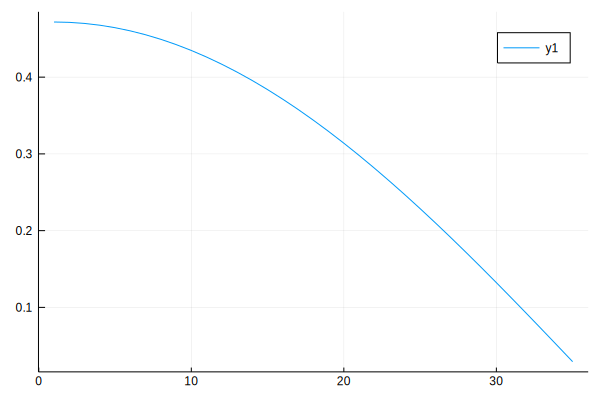

In [103]:
for k in 1:500
    iter!(state)
end
plot( state.T )

In [28]:
using BenchmarkTools

In [35]:
@btime iter!(state)
#   4.215 μs (29 allocations: 10.81 KiB)
#   4.050 μs (27 allocations: 10.78 KiB)
#   3.890 μs (29 allocations: 10.81 KiB)  with type def
#   3.370 μs (25 allocations: 9.89 KiB)   with in place S
#   2.633 μs (19 allocations: 6.33 KiB)  with I_plus_A

  2.646 μs (19 allocations: 6.33 KiB)


(2.252011e7, [-0.10825992512344006, -0.012582844628104044, -0.0014624800336272004, -0.00016998126512514155, -1.9756598264034096e-5, -2.296271737235724e-6, -2.6689128466141645e-7, -3.1020265011827304e-8, -3.605426241717616e-9, -4.190518159503073e-10  …  -8.174623672175255e-86, -9.501209191020556e-87, -1.1043074239466832e-87, -1.283515457945209e-88, -1.4918055381539028e-89, -1.7338971324994161e-90, -2.0152761385587893e-91, -2.3423660323848003e-92, -2.726704168075626e-93, -3.5320002177145423e-94])

In [50]:
function test(state, a)
    state.I_plus_A * a
end

test (generic function with 1 method)

In [56]:
typeof(S[1])

Float64

In [55]:
@btime test(state, a) setup=(a=rand(N))
#   1.063 μs (1 allocation: 896 bytes)    inverse
#   175.217 ns (1 allocation: 896 bytes)  sum
#   209.491 ns (1 allocation: 896 bytes) produit
# #   465.347 ns (11 allocations: 176 bytes)  call update_S

  211.202 ns (1 allocation: 896 bytes)


100-element Array{Float64,1}:
 0.3083886413796859 
 0.08095377048229922
 0.14431180561960052
 0.7183941628590877 
 0.7524611105788032 
 0.4909881156404826 
 0.19572680339006504
 0.29887391782591705
 0.5349496612734986 
 0.7200684541103309 
 0.7045988496623894 
 0.3981357217078018 
 0.8149949443272301 
 ⋮                  
 0.4958409467444562 
 0.6600161657419276 
 0.6906672687447506 
 0.6381906421804872 
 0.23087101213649083
 0.24219464010839561
 0.5085407009324917 
 0.46760894196259134
 0.2629401558558435 
 0.7827942116991566 
 0.601211058237685  
 0.65648870926009   

In [54]:
@btime state.update_S!(state.St, t) setup=(t=rand())
#   465.347 ns (11 allocations: 176 bytes)

  473.959 ns (11 allocations: 176 bytes)


0.0

## Verification case

Ozisik p279(149) example 7-12

BC: isolated and convection, initially at uniform temperature $T_0 = 1$